In [45]:
import numpy as np
from scipy.optimize import curve_fit
from numba import jit
import time

# Fonction modèle sigmoïde avec délai
def sigmoid(x, L, k, x0, b, d):
    return L / (1 + np.exp(-k * (x - x0))) + b * (x - d) * (x > d)


# Générer des données de test
np.random.seed(0)
n_curves = 22000
n_points = 20
x = np.linspace(0, 20, n_points)

def generate_noisy_sigmoid(x):
    L = np.random.uniform(0.5, 3) # Amplitude
    k = np.random.uniform(0.5, 2) # Pente
    x0 = np.random.uniform(3, 7) # Centre
    b = 0 # Pente linéaire
    d = np.random.uniform(5, 7) # Délai
    y = sigmoid(x, L, k, x0, b, d) # Valeurs réelles
    noise = np.random.normal(0, 0.05, n_points) # Bruit
    return y + noise

data = np.array([generate_noisy_sigmoid(x) for _ in range(n_curves)]).T



In [46]:
def fit_loop(data):
    results = []
    for i in range(data.shape[1]):
        popt, _ = curve_fit(sigmoid, x, data[:, i], p0=[np.max(data[:,i]), 1, 5, 0, 2], maxfev=5000)
        results.append(popt)
    return np.array(results)

# Méthode 2: Vectorisée avec NumPy
def fit_single_curve(y):
    popt, _ = curve_fit(sigmoid, x, y, p0=[np.max(y), 1, 5, 0, 2], maxfev=5000)
    return popt

def fit_vectorized(data):
    return np.apply_along_axis(fit_single_curve, 0, data)

In [47]:
from joblib import Parallel, delayed

def levenberg_marquardt_single_curve(x, y, initial_params, max_iterations, lambda_initial, lambda_reg):
    params = initial_params.copy()
    lambda_value = lambda_initial
    
    for _ in range(max_iterations):
        y_pred = sigmoid(x, *params)
        residuals = y - y_pred
        
        # Calcul du Jacobien
        exp_term = np.exp(-params[1] * (x - params[2]))
        sigmoid_term = 1 / (1 + exp_term)
        delay_mask = x > params[4]
        
        J = np.zeros((x.shape[0], len(params)))
        J[:, 0] = sigmoid_term
        J[:, 1] = params[0] * (x - params[2]) * exp_term * sigmoid_term**2
        J[:, 2] = -params[0] * params[1] * exp_term * sigmoid_term**2
        J[:, 3] = (x - params[4]) * delay_mask
        J[:, 4] = -params[3] * delay_mask
        
        # Calcul de l'incrément des paramètres
        JTJ = J.T @ J
        JTr = J.T @ residuals
        
        H = JTJ + lambda_value * np.diag(np.diag(JTJ)) + lambda_reg * np.eye(len(params))
        delta = np.linalg.solve(H, JTr)
        
        # Mise à jour des paramètres et de lambda
        new_params = params + delta
        new_residuals = y - sigmoid(x, *new_params)
        
        if np.sum(new_residuals**2) < np.sum(residuals**2):
            params = new_params
            lambda_value *= 0.1
        else:
            lambda_value *= 10
    
    return params

def levenberg_marquardt_vectorized(x, y, initial_params, max_iterations=50, lambda_initial=0.001, lambda_reg=1e-8, n_jobs=-1):
    n_curves = y.shape[1]
    results = Parallel(n_jobs=n_jobs)(delayed(levenberg_marquardt_single_curve)(
        x, y[:, i], initial_params, max_iterations, lambda_initial, lambda_reg) for i in range(n_curves))
    return np.array(results).T

In [48]:
# Méthode 3: Avec Numba
@jit(nopython=True)
def sigmoid_numba(x, L, k, x0, b, d):
    return L / (1 + np.exp(-k * (x - x0))) + b * (x - d) * (x > d)

@jit(nopython=True)
def fit_single_curve_numba(x, y):
    L, k, x0, b, d = 1.0, 1.0, 5.0, 0.1, 2.0
    
    for _ in range(1000):  # Itérations simplifiées
        y_pred = sigmoid_numba(x, L, k, x0, b, d)
        error = y - y_pred
        
        # Gradient descent simplifié
        L += np.sum(error * (1 / (1 + np.exp(-k * (x - x0))))) * 0.001
        k += np.sum(error * (L * (x - x0) * np.exp(-k * (x - x0)) / (1 + np.exp(-k * (x - x0)))**2)) * 0.0001
        x0 += np.sum(error * (-L * k * np.exp(-k * (x - x0)) / (1 + np.exp(-k * (x - x0)))**2)) * 0.0001
        b += np.sum(error * ((x - d) * (x > d))) * 0.001
        d += np.sum(error * (-b * (x > d))) * 0.001
        
    return L, k, x0, b, d

@jit(nopython=True)
def fit_numba(data):
    results = np.empty((5, data.shape[1]))
    for i in range(data.shape[1]):
        results[:, i] = fit_single_curve_numba(x, data[:, i])
    return results

In [49]:
# Fonction pour mesurer le temps d'exécution
def time_function(func, *args):
    start = time.time()
    result = func(*args)
    end = time.time()
    return end - start, result

In [50]:
# Mesurer les temps d'exécution
print("Mesure des temps d'exécution pour 22000 courbes:")

time_loop, _ = time_function(fit_loop, data)
print(f"Méthode avec boucle: {time_loop:.2f} secondes")

time_vectorized, _ = time_function(fit_vectorized, data)
print(f"Méthode vectorisée: {time_vectorized:.2f} secondes")

Mesure des temps d'exécution pour 22000 courbes:
Méthode avec boucle: 57.10 secondes
Méthode vectorisée: 58.07 secondes


In [51]:
# Fonction pour mesurer le temps d'exécution
def time_function(func, *args):
    start = time.time()
    result = func(*args)
    end = time.time()
    return end - start, result

# Mesurer le temps d'exécution
initial_params = [1.0, 1.0, 5.0, 0.1, 2.0]
time_vectorized, params_vectorized = time_function(levenberg_marquardt_vectorized, x, data, initial_params)

print(f"Méthode vectorisée Levenberg-Marquardt: {time_vectorized:.2f} secondes")

Méthode vectorisée Levenberg-Marquardt: 29.19 secondes


In [52]:
# Calculer les gains de performance
speedup_vectorized = time_loop / time_vectorized
speedup_numba = time_loop / time_vectorized

print(f"\nGain de performance de la méthode vectorisée: {speedup_vectorized:.2f}x")
print(f"Gain de performance de la méthode Numba: {speedup_numba:.2f}x")


Gain de performance de la méthode vectorisée: 1.96x
Gain de performance de la méthode Numba: 1.96x


[1.49564651e+00 1.01955693e+00 5.87086504e+00 3.76880895e-04
 3.15781186e+00]
[1.50009898e+00 1.01605372e+00 5.87550386e+00 7.52135255e-04
 3.00059229e+01]


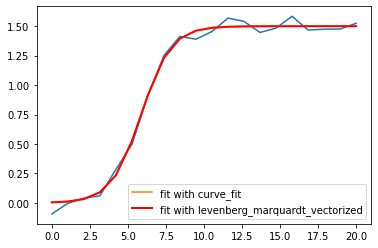

In [53]:
#plot the sigmoid data [1 st curve]
import matplotlib.pyplot as plt
index_curve = np.random.randint(0, n_curves)
plt.plot(x, data[:, index_curve])
popt, _ = curve_fit(sigmoid, x, data[:, index_curve], p0=[np.max(data[:,index_curve]), 1, 5, 0, 2], maxfev=5000)
#fit with levenberg_marquardt_vectorized
popt_levenberg = levenberg_marquardt_vectorized(x, data, initial_params)

print(popt)
print(popt_levenberg[:, index_curve])
plt.plot(x, sigmoid(x, *popt), label='fit with curve_fit')
plt.plot(x, sigmoid(x, *popt_levenberg[:, index_curve]), label='fit with levenberg_marquardt_vectorized', color='red', lw=2)
plt.legend()



In [54]:
import numpy as np
from scipy.optimize import curve_fit
import time

# Définir la fonction sigmoïde
def sigmoid(x, L, k, x0, b, d):
    exp_term = np.exp(-k * (x - x0))
    sigmoid_term = L / (1 + exp_term)
    delay_term = b * (x - d) * (x > d)
    return sigmoid_term + delay_term


# Initialiser les paramètres


# Mesurer le temps d'exécution pour l'ajustement des moindres carrés
start_time = time.time()
for i in range(n_curves):
    y = data[:, i]
    initial_params = [np.max(y), 1, 5, 0, 2]
    popt, pcov = curve_fit(sigmoid, x, y, p0=initial_params, maxfev=5000)
end_time = time.time()

execution_time = end_time - start_time
print(f"Temps d'exécution pour l'ajustement des moindres carrés: {execution_time:.2f} secondes")

Temps d'exécution pour l'ajustement des moindres carrés: 63.85 secondes


In [55]:
print(data.shape)

(20, 22000)


In [56]:
#met les data dans un dataframe 
import pandas as pd

df = pd.DataFrame(data)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,21990,21991,21992,21993,21994,21995,21996,21997,21998,21999
0,0.093755,0.101857,0.023611,0.020709,0.006654,0.031425,0.125186,-0.022245,0.046578,0.046601,...,0.017792,-0.003051,0.050818,0.002815,0.053196,-0.026044,0.014097,-0.034849,-0.053223,0.099718
1,-0.046892,0.173359,0.179801,-0.029906,0.021654,0.008535,0.062013,-0.011889,0.242049,0.023222,...,-0.012073,0.012643,0.187212,0.022955,0.062128,-0.041885,0.099990,-0.010442,0.069472,0.012516
2,0.057782,0.355776,0.323841,-0.012163,0.101994,0.310616,-0.009596,0.210601,0.251079,0.088335,...,-0.053587,-0.004651,0.477131,0.157249,0.054248,0.065435,0.008249,0.025074,0.344941,0.083876
3,0.045024,0.884943,0.603775,0.179998,-0.028256,1.089086,0.142330,0.352625,0.586172,0.278842,...,0.020618,0.084837,1.101270,0.118202,0.366326,0.045282,0.234726,-0.027674,1.108225,0.365648
4,0.240924,1.305389,1.034691,0.895873,0.123219,1.924740,0.134281,0.740201,0.952096,1.235898,...,0.128243,0.083491,1.967644,0.110309,1.223884,0.454782,1.026907,0.080324,2.164007,0.550724


In [57]:
# Appliquer curve_fit pour chaque colonne
start_time = time.time()
results = df.apply(lambda y: curve_fit(sigmoid, x, y, p0=[np.max(y), 1, 5, 0, 2], maxfev=5000)[0], axis=0) 

end_time = time.time()

execution_time = end_time - start_time
print(f"Temps d'exécution pour l'ajustement des moindres carrés: {execution_time:.2f} secondes")

c:\Users\Mehdi\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Temps d'exécution pour l'ajustement des moindres carrés: 62.61 secondes


In [58]:
from lmfit import Model

In [62]:
def fit_sigmoid(y, model):
    params = model.make_params(L=1, k=1, x0=5, b=0, d=6)
    result = model.fit(y, params, x=x)
    return result

In [64]:
# Ajuster le modèle aux données pour une courbe exemple
y_example = data[:, 0]
model = Model(sigmoid)
result = fit_sigmoid(y_example, model)
# Afficher les résultats de l'ajustement
print(result.fit_report())

[[Model]]
    Model(sigmoid)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 85
    # data points      = 20
    # variables        = 5
    chi-square         = 0.04213902
    reduced chi-square = 0.00280927
    Akaike info crit   = -113.250268
    Bayesian info crit = -108.271606
    R-squared          = 0.99648412
[[Variables]]
    L:   1.92774906 +/- 0.86882078 (45.07%) (init = 1)
    k:   1.56948716 +/- 0.49564738 (31.58%) (init = 1)
    x0:  5.43114286 +/- 0.11217712 (2.07%) (init = 5)
    b:  -0.00573314 +/- 0.00448799 (78.28%) (init = 0)
    d:   5.26313378 +/- 154.764251 (2940.53%) (init = 6)
[[Correlations]] (unreported correlations are < 0.100)
    C(L, d)  = -0.9989
    C(k, d)  = -0.9625
    C(L, k)  = +0.9560
    C(k, x0) = -0.8194
    C(x0, d) = +0.8102
    C(L, x0) = -0.7947
    C(x0, b) = -0.5795
    C(k, b)  = +0.4676
    C(b, d)  = -0.3847
    C(L, b)  = +0.3452


In [66]:
results = Parallel(n_jobs=-1)(delayed(fit_sigmoid)(y, model) for y in data.T)


In [343]:
# Générer des données de test
np.random.seed(0)
n_curves = 1000
n_points = 20
x = np.linspace(0, 20, n_points)

def generate_noisy_sigmoid(x):
    L = np.random.uniform(0.5, 3) # Amplitude
    k = 3#np.random.uniform(0.5, 1) # Pente
    x0 = 7#np.random.uniform(3, 7) # Centre
    b = 0 # Pente linéaire
    d = np.random.uniform(1, 7) # Délai
    y = sigmoid(x, L, k, x0, b, d) # Valeurs réelles
    noise = np.random.normal(0, 0.05, n_points) # Bruit
    return (y + noise, d)

data = []
delays = []
for i in range(n_curves):
    y, d = generate_noisy_sigmoid(x)
    data.append(y)
    delays.append(d)



[2.91902722e+00 3.12979227e+00 6.99961795e+00 4.60844313e-03
 1.05262862e+00]


Text(0.5, 1.0, 'Real delay: 1.80, Fit delay: 1.05')

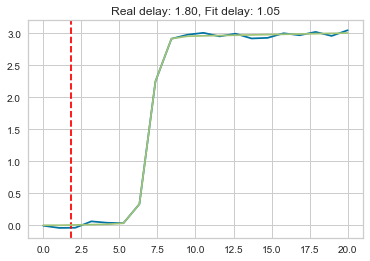

In [373]:
index_curve = np.random.randint(0, n_curves)
plt.plot(x, data[index_curve])
#add vertical line for delay
plt.axvline(x=delays[index_curve], color='red', linestyle='--', label='Delay')

popt, _ = curve_fit(sigmoid, x, data[index_curve], p0=[np.max(data[index_curve]), 1, 5, 0, 2], maxfev=5000)
print(popt)
plt.plot(x, sigmoid(x, *popt), label='fit with curve_fit')
#add on title the real delay and curve fit delay
plt.title(f"Real delay: {delays[index_curve]:.2f}, Fit delay: {popt[4]:.2f}")

In [250]:
#create a deeplearning model to predict the delay
import tensorflow as tf
from sklearn.model_selection import train_test_split
#import pycaret regression models
from pycaret.regression import *

#Normalised the data and the delay
data = np.array(data)
delays = np.array(delays)

normalised_data = data
normalised_delays = delays

#put data in df 
df = pd.DataFrame(normalised_data)
#add col with delays
df['delay'] = normalised_delays
df



,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,delay
0,0.093755,-0.046892,0.057782,0.045024,0.240924,0.848173,1.515689,1.862374,1.893773,1.874980,1.893627,1.888603,1.946716,1.861772,1.887686,1.829329,1.744384,1.904715,1.915256,1.834926,6.089766
1,0.101857,0.173359,0.355776,0.884943,1.305389,1.460490,1.602757,1.643278,1.700704,1.700209,1.620941,1.625244,1.587944,1.569374,1.555062,1.737915,1.614893,1.618472,1.577736,1.679250,6.235271
2,0.023611,0.179801,0.323841,0.603775,1.034691,1.360380,1.520390,1.617804,1.608132,1.637129,1.627916,1.646095,1.624435,1.579188,1.674538,1.645643,1.584249,1.688909,1.620409,1.668373,5.220750
3,0.020709,-0.029906,-0.012163,0.179998,0.895873,1.684269,1.841837,1.979393,1.962396,1.862951,2.014265,2.034659,1.998805,1.930870,1.886329,1.992589,1.919707,2.000988,1.950280,1.988698,6.334821
4,0.006654,0.021654,0.101994,-0.028256,0.123219,0.785638,1.710949,2.545531,2.628824,2.655932,2.798294,2.777930,2.797630,2.749624,2.661274,2.799841,2.690938,2.744461,2.751701,2.696588,6.002649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.007719,-0.103167,-0.086910,-0.028608,0.146226,0.728147,1.606705,1.909626,2.044392,2.008077,2.023539,2.031773,2.125758,2.069162,2.011205,2.004298,2.014492,1.947204,2.054657,2.013519,6.849438
996,-0.032354,0.049140,0.200497,0.588208,1.472893,2.213178,2.648607,2.709925,2.787875,2.687441,2.735651,2.733311,2.700813,2.735306,2.758751,2.731946,2.772167,2.727702,2.720034,2.796261,5.714958
997,-0.020066,0.106452,0.026521,0.042844,0.246228,0.694939,0.905181,1.159343,1.182655,1.178134,1.124339,1.117636,1.057125,1.173693,1.143396,1.099463,1.145206,1.074933,1.080015,1.094205,6.360304
998,0.109064,0.378238,0.693455,1.283853,1.941472,2.390959,2.626647,2.624486,2.965391,2.881675,2.929188,2.851099,2.921398,2.822201,2.913378,2.808203,2.885022,2.751368,2.863270,2.903235,5.584343


In [251]:
reg = setup(data = df, target = 'delay', session_id=123)
#compare all models
best = compare_models()

,Description,Value
0,Session id,123
1,Target,delay
2,Target type,Regression
3,Original data shape,"(1000, 21)"
4,Transformed data shape,"(1000, 21)"
5,Transformed train set shape,"(700, 21)"
6,Transformed test set shape,"(300, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lasso,Lasso Regression,0.5082,0.3418,0.5844,-0.0110,0.0840,0.0859,0.0110
llar,Lasso Least Angle Regression,0.5082,0.3418,0.5844,-0.0110,0.0840,0.0859,0.0120
dummy,Dummy Regressor,0.5082,0.3418,0.5844,-0.0110,0.0840,0.0859,0.0110
en,Elastic Net,0.5082,0.3418,0.5844,-0.0110,0.0840,0.0859,0.0120
omp,Orthogonal Matching Pursuit,0.5060,0.3424,0.5847,-0.0116,0.0840,0.0856,0.0160
ada,AdaBoost Regressor,0.5080,0.3425,0.5847,-0.0116,0.0840,0.0858,0.0330
br,Bayesian Ridge,0.5086,0.3423,0.5848,-0.0122,0.0840,0.0860,0.0110
ridge,Ridge Regression,0.5101,0.3483,0.5894,-0.0276,0.0847,0.0863,0.0100
lr,Linear Regression,0.5141,0.3557,0.5955,-0.0488,0.0855,0.0869,0.5990
lar,Least Angle Regression,0.5150,0.3567,0.5964,-0.0519,0.0857,0.0871,0.0120
